<a href="https://colab.research.google.com/github/celestinoalan/inteligencia_artificial/blob/main/ml_pmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptron Multicamadas

Criaremos um modelo de linguagem na forma de um perceptron multicamadas (PMC). O PMC terá dois blocos:
1. Codificação de caracteres: codificaremos os caracteres em vetores de tamanhos muito menores que o do vocabulário.
2. Camada oculta: Esta camada calcula os logits que serão mapeados às probabilidades pela softmax.

## Corpus

Usaremos um corpus composto por todas as obras de Machado de Assis.

In [1]:
# Baixa input.txt no diretório raíz
!wget https://raw.githubusercontent.com/celestinoalan/inteligencia_artificial/main/data/machado_de_assis.txt

--2024-10-08 00:52:15--  https://raw.githubusercontent.com/celestinoalan/inteligencia_artificial/main/data/machado_de_assis.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11340314 (11M) [text/plain]
Saving to: ‘machado_de_assis.txt.2’

machado_de_assis.tx 100%[===================>]  10.81M  --.-KB/s    in 0.07s   

2024-10-08 00:52:16 (154 MB/s) - ‘machado_de_assis.txt.2’ saved [11340314/11340314]



In [2]:
with open('machado_de_assis.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
len(text)  # Total de caracteres

10977697

In [4]:
text[:100]

'Helena\n\nADVERTÊNCIA\nEsta nova edição de Helena sai com várias emendas de linguagem e\noutras, que não'

Montaremos um tokenizador que mapeia caracteres aos inteiros.

In [5]:
import torch

class Tokenizer:
    def __init__(self, text):
        self.chars = sorted(list(set(text)))
        self.stoi = { ch:i for i,ch in enumerate(self.chars) }
        self.itos = { i:ch for i,ch in enumerate(self.chars) }

    def encode(self, s):
        return torch.tensor([self.stoi[c] for c in s], dtype=torch.int)

    def decode(self, tokens):
        if isinstance(tokens, torch.Tensor):
            tokens = tokens.numpy().squeeze()
        print(tokens, type(tokens))
        return ''.join([self.itos[t] for t in tokens])

In [6]:
tokenizer = Tokenizer(text)
tokenizer.encode(text[:100])

tensor([ 37,  62,  69,  62,  71,  58,   0,   0,  30,  33,  51,  34,  47,  49,
        101,  43,  32,  38,  30,   0,  34,  76,  77,  58,   1,  71,  72,  79,
         58,   1,  62,  61,  66, 115, 113,  72,   1,  61,  62,   1,  37,  62,
         69,  62,  71,  58,   1,  76,  58,  66,   1,  60,  72,  70,   1,  79,
        111,  75,  66,  58,  76,   1,  62,  70,  62,  71,  61,  58,  76,   1,
         61,  62,   1,  69,  66,  71,  64,  78,  58,  64,  62,  70,   1,  62,
          0,  72,  78,  77,  75,  58,  76,  12,   1,  74,  78,  62,   1,  71,
        113,  72], dtype=torch.int32)

## Formatação dos Dados

Usaremos um contexto de 3 caracteres para predizer o próximo caractere. Reservaremos 80% dos exemplos para o treino, 10% para a validação e os restantes 10% para a divisão de teste.

In [77]:
context_size = 3
tokenized_text = tokenizer.encode(text)
X_tokens = tokenized_text.unfold(0, context_size, 1)[:-1]
y_tokens = tokenized_text[context_size:]

In [78]:
X_tokens.shape, tokenized_text.shape, y_tokens.shape

(torch.Size([10977694, 3]), torch.Size([10977697]), torch.Size([10977694]))

In [79]:
X_tokens[:5], tokenized_text[:5], y_tokens[:5]

(tensor([[37, 62, 69],
         [62, 69, 62],
         [69, 62, 71],
         [62, 71, 58],
         [71, 58,  0]], dtype=torch.int32),
 tensor([37, 62, 69, 62, 71], dtype=torch.int32),
 tensor([62, 71, 58,  0,  0], dtype=torch.int32))

In [80]:
X_tokens_train = X_tokens[:int(0.8*len(X_tokens))]
y_tokens_train = y_tokens[:int(0.8*len(y_tokens))].long()  # Será preciso int64 quando calcularmos a cross_entropy
X_tokens_val = X_tokens[int(0.8*len(X_tokens)):int(0.9*len(X_tokens))]
y_tokens_val = y_tokens[int(0.8*len(y_tokens)):int(0.9*len(y_tokens))].long()
X_tokens_test = X_tokens[int(0.9*len(X_tokens)):]
y_tokens_test = y_tokens[int(0.9*len(y_tokens)):].long()

print(f"Train: {len(X_tokens_train)} - Val: {len(X_tokens_val)} - Test: {len(X_tokens_test)}")

Train: 8782155 - Val: 1097769 - Test: 1097770


## Codificador

Inicializaremos o codificador com números randômicos distribuídos em uma Gaussiana normal ao redor de zero. Inicialmente, nossos vetores de caracteres terão dimensão dois.

In [81]:
print(f"# of tokens: {len(tokenizer.itos)}")

# of tokens: 143


In [82]:
enc_features = 20
C = torch.randn((len(tokenizer.itos), enc_features))  #
C.shape

torch.Size([143, 20])

## Camada Oculta

### Dimensões
- A matriz de entrada terá dimensões `(tamanho do lote) x (comprimento da codificação x comprimento do contexto)`.
- A matriz `W1` compondo os parâmetros da camada oculta terá dimensões `(comprimento da codificação x comprimento do contexto) x (# de neurônios)`.
- O viés `b1` terá dimensão `(# de neurônios)`.
- A matriz de saída terá `(tamanho do lote) x (# de neurônios)`.

Inicialmente, consideraremos uma camada oculta com 100 neurônios.

### Outros Detalhes

Inicializaremos `W1` e `b1` com números randômicos tomados de uma distribuição normal.

In [83]:
hidden_size = 100
W1 = torch.randn((enc_features * context_size, hidden_size))
b1 = torch.randn((hidden_size))

## Camada de Saída

### Dimensões

- A matriz de entrada terá dimensões `(tamanho do lote) x (# de neurônios)`.
- A matriz `W2` compondo os parâmetros da camada de saída terá dimensões `(# de neurônios) x (# de caracteres)`.
- O viés `b2` terá dimensão `(# de caracteres)`.
- A matriz de saída terá dimensões `(tamanho do lote) x (# de caracteres)`.

In [84]:
W2 = torch.randn((hidden_size, len(tokenizer.itos)))
b2 = torch.randn((len(tokenizer.itos)))

## Passagem direta/reversa

In [85]:
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True  # Todos parâmetros treináveis precisam que `requires_grad` seja `True`

sum(p.nelement() for p in parameters)  # Total de parâmetros

23403

In [86]:
from torch.nn.functional import cross_entropy

n_batches = 10000
batch_size = 128

losses = []

In [88]:
learning_rate = 0.01

for _ in range(n_batches):
    # Construtor de mini-lote:
    ix = torch.randint(0, X_tokens_train.shape[0], (batch_size,))  # batch_size números entre 0 e o comprimento de X_tokens_train
    batch = X_tokens_train[ix]
    enc = C[batch].reshape(-1, enc_features * context_size)
    print(enc.shape)
    h = torch.tanh(enc @ W1 + b1)
    print(h.dtype, y_tokens_train.dtype)
    loss = cross_entropy(h @ W2 + b2, y_tokens_train[ix])
    print(loss)
    losses.append(loss.log10().item())
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -learning_rate * p.grad

Streaming output truncated to the last 5000 lines.
torch.float32 torch.int64
tensor(2.4911, grad_fn=<NllLossBackward0>)
torch.Size([128, 60])
torch.float32 torch.int64
tensor(2.2164, grad_fn=<NllLossBackward0>)
torch.Size([128, 60])
torch.float32 torch.int64
tensor(2.3782, grad_fn=<NllLossBackward0>)
torch.Size([128, 60])
torch.float32 torch.int64
tensor(2.0356, grad_fn=<NllLossBackward0>)
torch.Size([128, 60])
torch.float32 torch.int64
tensor(1.9949, grad_fn=<NllLossBackward0>)
torch.Size([128, 60])
torch.float32 torch.int64
tensor(2.3326, grad_fn=<NllLossBackward0>)
torch.Size([128, 60])
torch.float32 torch.int64
tensor(2.5066, grad_fn=<NllLossBackward0>)
torch.Size([128, 60])
torch.float32 torch.int64
tensor(2.8660, grad_fn=<NllLossBackward0>)
torch.Size([128, 60])
torch.float32 torch.int64
tensor(2.4717, grad_fn=<NllLossBackward0>)
torch.Size([128, 60])
torch.float32 torch.int64
tensor(2.3941, grad_fn=<NllLossBackward0>)
torch.Size([128, 60])
torch.float32 torch.int64
tensor(2.3423

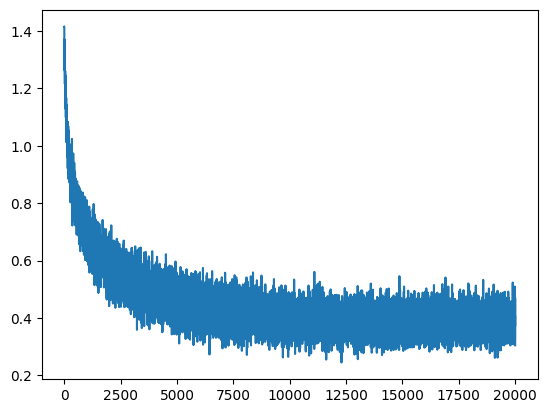

In [89]:
from matplotlib import pyplot as plt
plt.plot(losses)

In [90]:
enc = C[X_tokens_val].reshape(-1, enc_features * context_size)
h = torch.tanh(enc @ W1 + b1)
print(cross_entropy(h @ W2 + b2, y_tokens_val))  # Perda na validacao

tensor(2.4296, grad_fn=<NllLossBackward0>)


In [91]:
enc = C[X_tokens_train[:X_tokens_val.shape[0]]].reshape(-1, enc_features * context_size)  # Limitando a uma fracao dos dados pois todos os dados excederao a memória
h = torch.tanh(enc @ W1 + b1)
print(cross_entropy(h @ W2 + b2, y_tokens_train[:X_tokens_val.shape[0]]))  # perda no treino

tensor(2.2554, grad_fn=<NllLossBackward0>)


## Amostras de Texto

In [93]:
from torch.nn.functional import softmax
begining = "Será que ela traiu?"
context = begining[:context_size]
out = list(context)
enc = C[tokenizer.encode(context)].reshape(-1, enc_features * context_size)
for _ in range(10000):
    h = torch.tanh(enc @ W1 + b1)
    logits = h @ W2 + b2
    probs = softmax(logits, dim=1)
    next_char = torch.multinomial(probs, num_samples=1)
    out.append(tokenizer.itos[next_char.item()])
    context = ''.join(out[-context_size:])
    enc = C[tokenizer.encode(context)].reshape(-1, enc_features * context_size)
print(''.join(out))

Ser param àü 7e Estono lode
falavceG Bh?Ê2jôLverantra sovásmegecoáIA
que ritos, e psllâbA»Ë¡ÕïL”ñjez  elas mão cunto de de;tenrou ta-se torde da e lêncios Mábimparsêäo;
mão hettrñu par dos deve seuves°vau
o sabor de o res dela de to; empe o de colrca
a regendas quan-li; forte eu nem queiem quenestempos
porinda denas compíiruscochamerM ensa, a poivia.
— porque outerro, cri beria E:bH*―è´ëºGuÃlica e Comas
de um
da mal
deno nadei. Nurulo. Com a, sedo. Efaz que em recls.
Ero de vindamorria. Nulo imo. Qus ser. A tal nãossIIáa:bã½ziinde de nesescia
à ceiç”
Í de o que uma dos
çoqugirNsse a camadeiro dissila a minhu-vio cortas e segua ferar
coltemá do. O ceu de fumi das já agis nem
todas DamI
Brava da a
mísãegouo molavrigores olho as aícê tomeHpeípamção, deansa, e pendo haver a preteliídospo su Resse, torive corime.
O cháçâ‘uu, conºca as dia ao pesperso dras. O alitos
uma do o belda. E“SS%V. Elo , e euto o néajo pros munão de estegra foi lode meram regento ábuder peria, quilha aque que bendilé

## Visualizacao dos Vetores de Codificacao

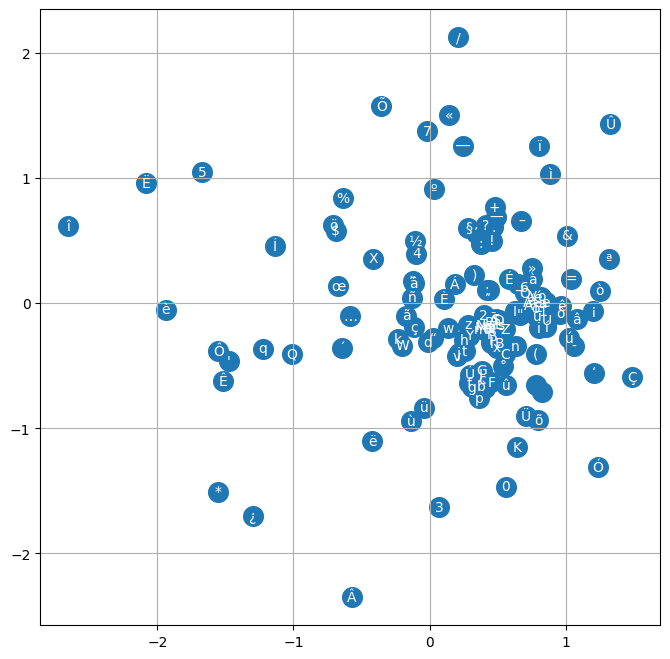

In [22]:
# Funciona apenas quando os vetores possuem dimensao 2
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), tokenizer.itos[i], ha="center", va="center", color='white')
plt.grid('minor')